In [1]:
import os
import cv2
import random
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop, AdamW
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.metrics import Precision, Recall, AUC, F1Score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, Input
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

2024-12-04 03:38:11.108714: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-04 03:38:11.293856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733254691.359518   37189 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733254691.378265   37189 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 03:38:11.530583: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
SEED = 42

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)

In [3]:
train_path = 'data/chest_xray/train'
test_path = 'data/chest_xray/test'
val_path = 'data/chest_xray/val'

labels = ['PNEUMONIA', 'NORMAL']
IMG_SIZE = 224
GRAYSCALE = True

In [4]:
def load_data(data_dir, img_size, grayscale=True):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE) if grayscale else cv2.imread(os.path.join(path, img))
                if img_arr is None:
                    continue
                resized_img = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_img, class_num])
            except Exception as e:
                print(f"Error processing image {img}: {e}")
    return np.array(data, dtype=object)

def split_features_labels(data):
    x, y = zip(*data)
    return list(x), list(y)

def plot_labels_distribution(data, title):
    label_list = []
    for i in data:
        if i[1] == 0:
            label_list.append("Pneumonia")
        else:
            label_list.append("Normal")

    label_series = pd.Series(label_list, name="Class")
    print(label_series.value_counts())

    sns.set_style('whitegrid')
    sns.countplot(x=label_series, palette=['#ff7f0e', '#1f77b4'], hue=label_series, legend=False)

    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

def plot_dataset_distribution(train, val, test):
    sizes = [len(train), len(val), len(test)]
    colors = ['#ff9999', '#66b3ff', '#99ff99']
    labels = ['Train', 'Validation', 'Test']

    plt.figure(figsize=(6, 6))
    wedges, texts, autotexts = plt.pie(sizes, autopct='%1.1f%%', startangle=140, colors=colors)
    plt.legend(wedges, labels)
    plt.title('Data Distribution')
    plt.axis('equal')  
    plt.show()

Train data: 5216
Validation data: 16
Test data: 624


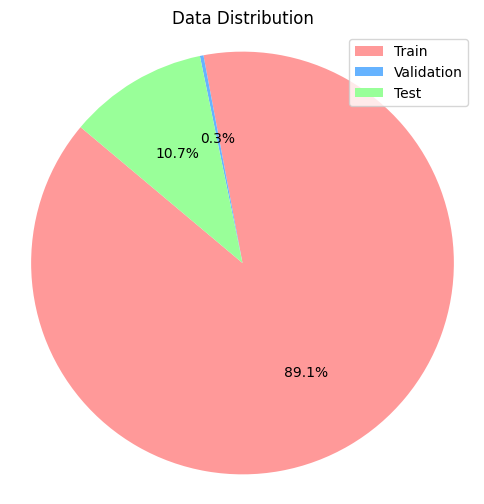

In [5]:
train = load_data(train_path, IMG_SIZE, GRAYSCALE)
test = load_data(test_path, IMG_SIZE, GRAYSCALE)
val = load_data(val_path, IMG_SIZE, GRAYSCALE)

print(f"Train data: {len(train)}")
print(f"Validation data: {len(val)}")
print(f"Test data: {len(test)}")

plot_dataset_distribution(train, val, test)

In [6]:
# combine the data
combined_data = np.concatenate((train, val, test), axis=0)

# split into train, test and validation (80%, 10%, 10%)
new_train, new_val = train_test_split(combined_data, test_size=0.2, random_state=SEED)
new_test, new_val = train_test_split(new_val, test_size=0.5, random_state=SEED)

Redistributed train data: 4684
Redistributed validation data: 586
Redistributed test data: 586


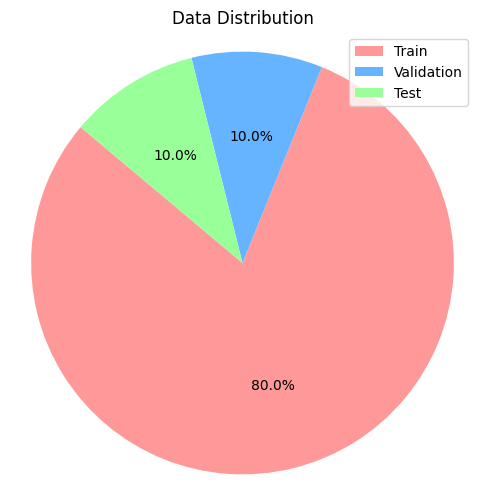

In [7]:
print(f"Redistributed train data: {len(new_train)}")
print(f"Redistributed validation data: {len(new_val)}")
print(f"Redistributed test data: {len(new_test)}")

plot_dataset_distribution(new_train, new_val, new_test)

In [8]:
# define data augmentation methods
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images horizontally
        vertical_flip=False) 

def augment_data(data, datagen, img_size, grayscale=True, augment_fold=2):
    augmented_data = []
    for img, label in data:
        img = img.reshape((1, img_size, img_size, 1)) if grayscale else img.reshape((1, img_size, img_size, 3))
        aug_iter = datagen.flow(img, batch_size=1)
        for _ in range(augment_fold):  # augment each image twice
            # randomly skip some augmented images
            if random.random() < 0.30:
                continue
            aug_img = next(aug_iter)[0].reshape((img_size, img_size)) if grayscale else next(aug_iter)[0].reshape((img_size, img_size, 3))
            augmented_data.append([aug_img, label])
    return augmented_data

Class
Pneumonia    3407
Normal       1277
Name: count, dtype: int64


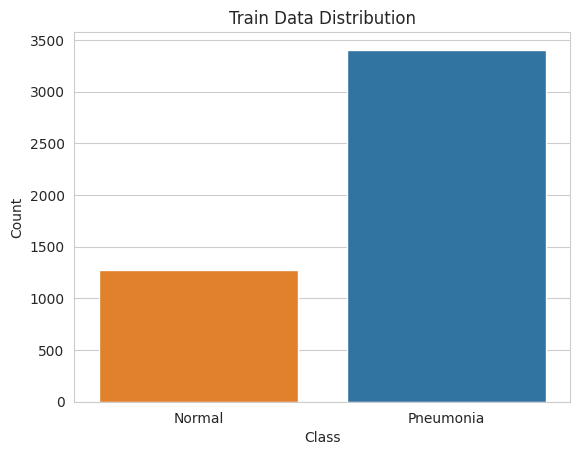

In [9]:
plot_labels_distribution(new_train, "Train Data Distribution")

Class
Pneumonia    429
Normal       157
Name: count, dtype: int64


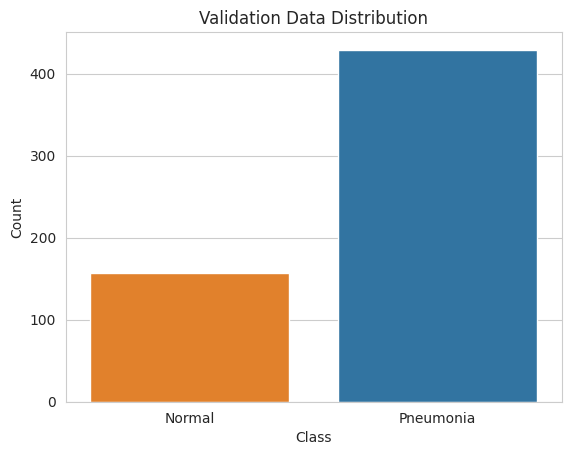

In [10]:
plot_labels_distribution(new_val, "Validation Data Distribution")

Class
Pneumonia    437
Normal       149
Name: count, dtype: int64


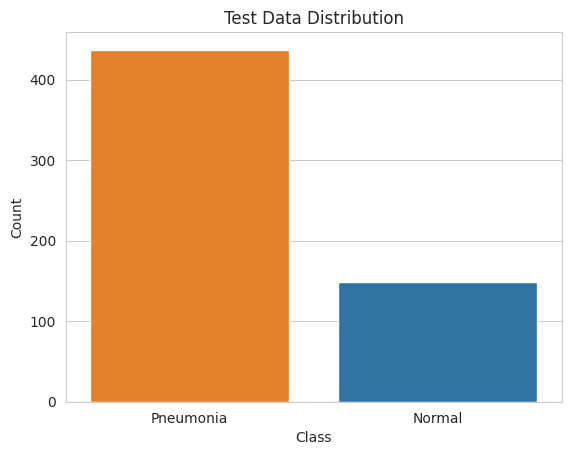

In [11]:
plot_labels_distribution(new_test, "Test Data Distribution")

In [12]:
# perform data augmentation on normal images (minority class)
train_normal_data = [new_train[i] for i in range(len(new_train)) if new_train[i][1] == 1]
augmented_train_normal = augment_data(train_normal_data, datagen, IMG_SIZE, GRAYSCALE, augment_fold=2)

if isinstance(new_train, np.ndarray):
    new_train = new_train.tolist()

augmented_train_data = new_train + augmented_train_normal
np.random.shuffle(augmented_train_data)
augmented_train_data = np.array(augmented_train_data, dtype=object)

# ===
val_normal_data = [new_val[i] for i in range(len(new_val)) if new_val[i][1] == 1]
augmented_val_normal = augment_data(val_normal_data, datagen, IMG_SIZE, GRAYSCALE, augment_fold=2)

if isinstance(new_val, np.ndarray):
    new_val = new_val.tolist()

augmented_val_data = new_val + augmented_val_normal
np.random.shuffle(augmented_val_data)
augmented_val_data = np.array(augmented_val_data, dtype=object)

Train data: 6501
Test data: 586
Validation data: 793


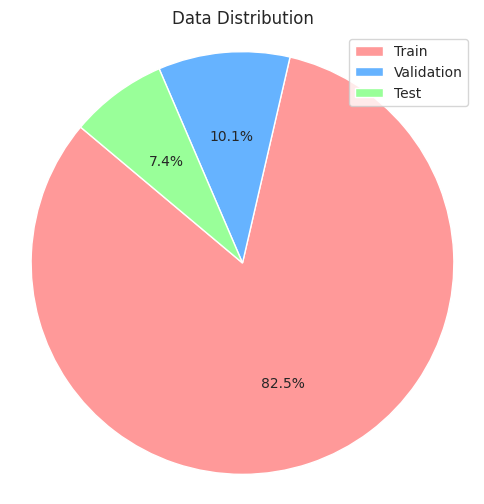

In [13]:
print(f"Train data: {len(augmented_train_data)}")
print(f"Test data: {len(new_test)}")
print(f"Validation data: {len(augmented_val_data)}")

plot_dataset_distribution(augmented_train_data, augmented_val_data, new_test)


Class
Pneumonia    3407
Normal       3094
Name: count, dtype: int64


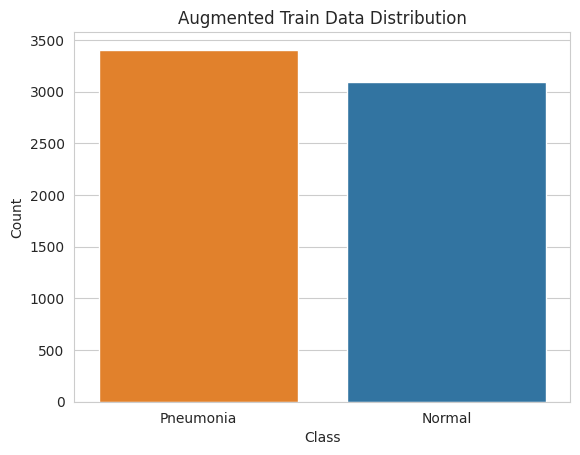

In [14]:
# check data distributions again
plot_labels_distribution(augmented_train_data, "Augmented Train Data Distribution")

Class
Pneumonia    429
Normal       364
Name: count, dtype: int64


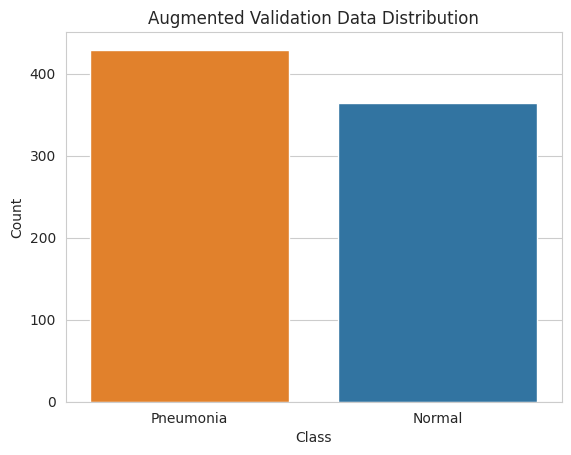

In [15]:
plot_labels_distribution(augmented_val_data, "Augmented Validation Data Distribution")

In [16]:
# split data into features and labels
x_train, y_train = split_features_labels(augmented_train_data)
x_val, y_val = split_features_labels(new_val)
x_test, y_test = split_features_labels(new_test)

In [17]:
def normalize_data(data):
    return np.array(data) / 255

def reshape_data(data, img_size, grayscale=True):
    return data.reshape(-1, img_size, img_size, 1) if grayscale else data.reshape(-1, img_size, img_size, 3)


# normalize and reshape data
x_train = normalize_data(x_train)
x_train = reshape_data(x_train, IMG_SIZE, GRAYSCALE)
y_train = np.array(y_train)


x_val = normalize_data(x_val)
x_val = reshape_data(x_val, IMG_SIZE, GRAYSCALE)
y_val = np.array(y_val)

x_test = normalize_data(x_test)
x_test = reshape_data(x_test, IMG_SIZE, GRAYSCALE)
y_test = np.array(y_test)

In [18]:
print(f"x_train shape: {x_train.shape}, dtype: {x_train.dtype}")
print(f"y_train shape: {y_train.shape}, dtype: {y_train.dtype}")

print(f"x_val shape: {x_val.shape}, dtype: {x_val.dtype}")
print(f"y_val shape: {y_val.shape}, dtype: {y_val.dtype}")

print(f"x_test shape: {x_test.shape}, dtype: {x_test.dtype}")
print(f"y_test shape: {y_test.shape}, dtype: {y_test.dtype}")

x_train shape: (6501, 224, 224, 1), dtype: float32
y_train shape: (6501,), dtype: int64
x_val shape: (586, 224, 224, 1), dtype: float64
y_val shape: (586,), dtype: int64
x_test shape: (586, 224, 224, 1), dtype: float64
y_test shape: (586,), dtype: int64


# Model Building

In [19]:
def build_base_model(optimizer, input_shape=(150, 150, 1)):
    model = Sequential()

    # convolutional layer 1
    model.add(Conv2D(32 , (3,3) , strides=1 , padding='same' , activation = 'relu', input_shape=input_shape, name="conv1_1"))
    model.add(BatchNormalization(name="batchnorm_1"))
    model.add(MaxPool2D((2,2) , strides=2 , padding = 'same', name="maxpool2d_1"))

    # convolutional layer 2
    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu', name="conv2_1"))
    model.add(Dropout(0.1, name="dropout_1"))
    model.add(BatchNormalization(name="batchnorm_2"))
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same', name="maxpool2d_2"))

    # convolutional layer 3
    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu', name="conv3_1"))
    model.add(BatchNormalization(name="batchnorm_3"))
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same', name="maxpool2d_3"))

    # convolutional layer 4
    model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu', name="conv4_1"))
    model.add(Dropout(0.2, name="dropout_2"))
    model.add(BatchNormalization(name="batchnorm_4"))
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same', name="maxpool2d_4"))

    # convolutional layer 5
    model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu', name="conv5_1"))
    model.add(Dropout(0.2, name="dropout_3"))
    model.add(BatchNormalization(name="batchnorm_5"))
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same', name="maxpool2d_5"))

    # flattening the layers
    model.add(Flatten(name='flatten'))

    # fully connected layer 1
    model.add(Dense(units=128 , activation = 'relu', name='fc1'))
    model.add(Dropout(0.3, name="dropout_4"))

    # output layer
    model.add(Dense(units=1 , activation = 'sigmoid', name='output'))

    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

optimizer = RMSprop()
model = build_base_model(optimizer=optimizer, input_shape=(IMG_SIZE, IMG_SIZE, 1))
model.summary()

I0000 00:00:1733254768.583567   37189 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
/home/an/miniconda3/envs/aa1_test/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_1 (Conv2D)                │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1 (MaxPooling2D)      │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2 (MaxPooling2D)      │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_3                     │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_3 (MaxPooling2D)      │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4_1 (Conv2D)                │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_4                     │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_4 (MaxPooling2D)      │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5_1 (Conv2D)                │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_5                     │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_5 (MaxPooling2D)      │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 2,032,833 (7.75 MB)

 Trainable params: 2,031,745 (7.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

# Model training

In [ ]:
BATCH_SIZE = 16
EPOCHS = 15

train_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_type = 'cnn'

# callback to reduce learning rate when the model stops improving
lr_reduction_callback = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=1e-6)

# save best model
checkpoint_filepath = os.path.join('models', model_type, train_time, "checkpoint.model.keras")
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True)

# tensorboard callback
log_dir = os.path.join("logs", model_type, train_time)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True, verbose=1)



In [21]:
history = model.fit(x=x_train, 
                    y=y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    validation_data=(x_val, y_val), 
                    callbacks=[lr_reduction_callback, model_checkpoint_callback, tensorboard_callback, early_stopping_callback])

Epoch 1/15


2024-12-04 03:39:31.532942: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
E0000 00:00:1733254773.074338   37189 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/dropout_1_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1733

407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8247 - loss: 1.1498

2024-12-04 03:40:04.874921: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Epoch 1: val_accuracy improved from -inf to 0.73208, saving model to models/cnn/20241204-033929/checkpoint.model.keras
407/407 ━━━━━━━━━━━━━━━━━━━━ 36s 79ms/step - accuracy: 0.8248 - loss: 1.1481 - val_accuracy: 0.7321 - val_loss: 10.5961 - learning_rate: 0.0010
Epoch 2/15
406/407 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9369 - loss: 0.2040
Epoch 2: val_accuracy improved from 0.73208 to 0.87884, saving model to models/cnn/20241204-033929/checkpoint.model.keras
407/407 ━━━━━━━━━━━━━━━━━━━━ 29s 72ms/step - accuracy: 0.9369 - loss: 0.2039 - val_accuracy: 0.8788 - val_loss: 0.3313 - learning_rate: 0.0010
Epoch 3/15
406/407 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9510 - loss: 0.1540
Epoch 3: val_accuracy improved from 0.87884 to 0.94369, saving model to models/cnn/20241204-033929/checkpoint.model.keras
407/407 ━━━━━━━━━━━━━━━━━━━━ 29s 72ms/step - accuracy: 0.9510 - loss: 0.1540 - val_accuracy: 0.9437 - val_loss: 0.1487 - learning_rate: 0.0010
Epoch 4/15
406/407 ━━━━━━━━━━━━━

In [22]:
# load best model
model = load_model(checkpoint_filepath)

# Model evaluation

In [23]:
res_dir = os.path.join("res", model_type, train_time)
os.makedirs(res_dir, exist_ok=True)

In [24]:
print("Test Set Evaluation")
# loss, accuracy = model.evaluate(x_test, y_test)
# print(f"Loss: {loss}")
# print(f"Accuracy: {accuracy * 100}%")
print(model.evaluate(x_test, y_test))

Test Set Evaluation


2024-12-04 03:47:04.559219: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9539 - loss: 0.1325
[0.12427998334169388, 0.9658703207969666]


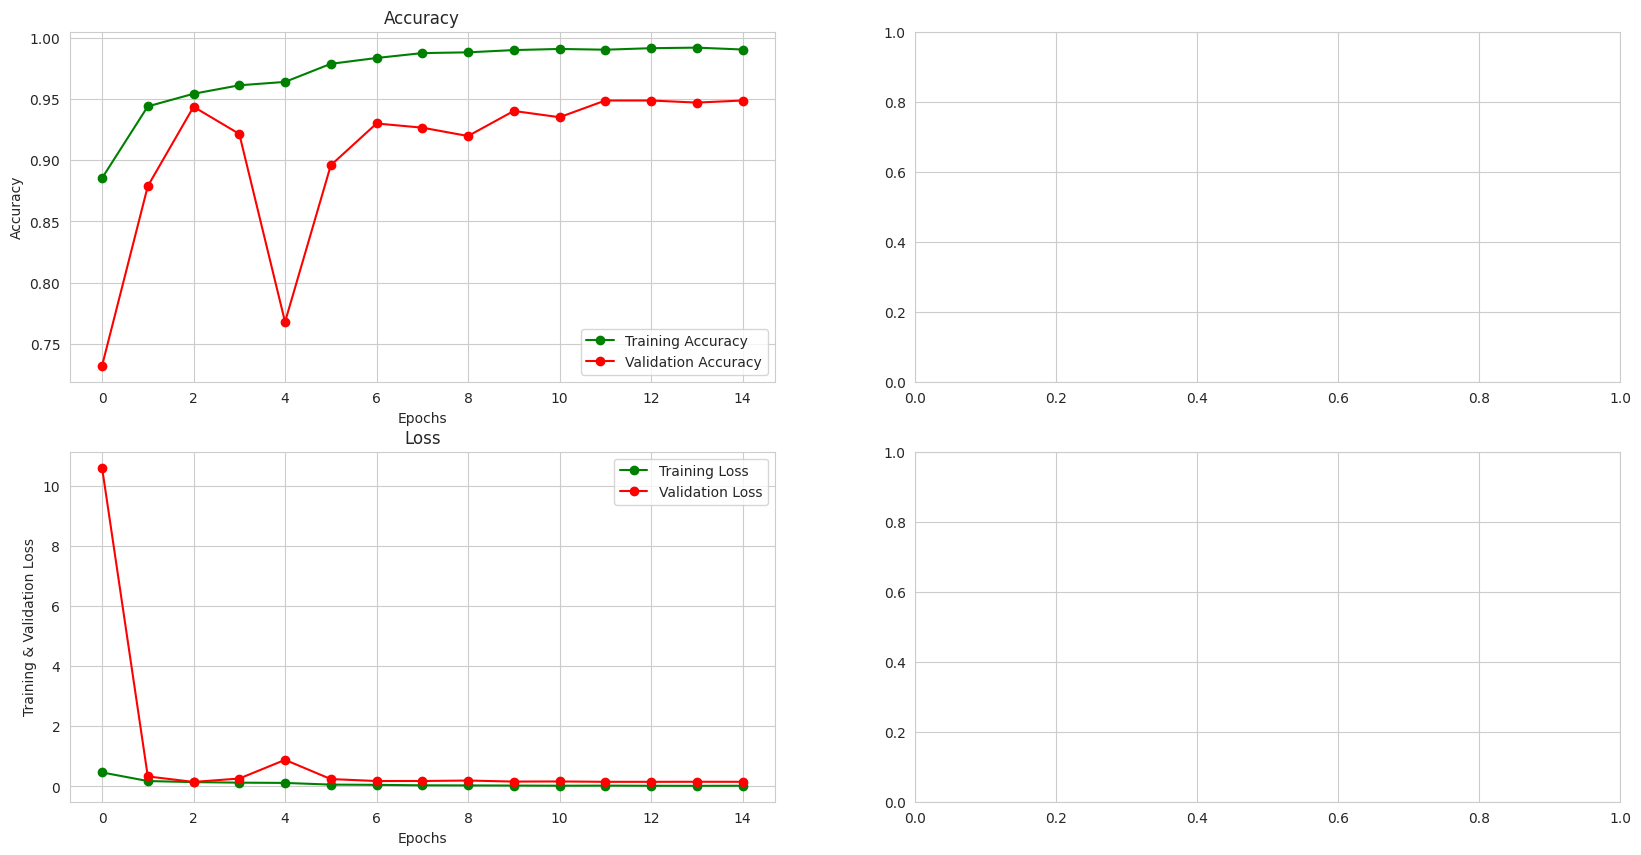

In [25]:
x_epochs = [i for i in range(EPOCHS)]
fig , ax = plt.subplots(2,2)
fig.set_size_inches(20,10)

# train metrics
train_acc = history.history['accuracy']
train_loss = history.history['loss']
# train_auc = history.history['auc']

# validation metrics
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
# val_auc = history.history['val_auc']

ax[0, 0].plot(x_epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0, 0].plot(x_epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0, 0].set_title('Accuracy')
ax[0, 0].legend()
ax[0, 0].set_xlabel("Epochs")
ax[0, 0].set_ylabel("Accuracy")

# ax[0, 1].plot(x_epochs , train_auc , 'go-' , label = 'Training AUC')
# ax[0, 1].plot(x_epochs , val_auc , 'ro-' , label = 'Validation AUC')
# ax[0, 1].set_title('AUC')
# ax[0, 1].legend()
# ax[0, 1].set_xlabel("Epochs")
# ax[0, 1].set_ylabel("Training & Validation AUC")

ax[1, 0].plot(x_epochs, train_loss, 'g-o', label='Training Loss')
ax[1, 0].plot(x_epochs, val_loss, 'r-o', label='Validation Loss')
ax[1, 0].set_title('Loss')
ax[1, 0].legend()
ax[1, 0].set_xlabel("Epochs")
ax[1, 0].set_ylabel("Training & Validation Loss")

plt.show()

fig.savefig(os.path.join(res_dir, "training_results.png"))

In [26]:
predictions = (model.predict(x_test) > 0.5).astype(int) # for binary classification
predictions = predictions.reshape(predictions.shape[0])
predictions

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,

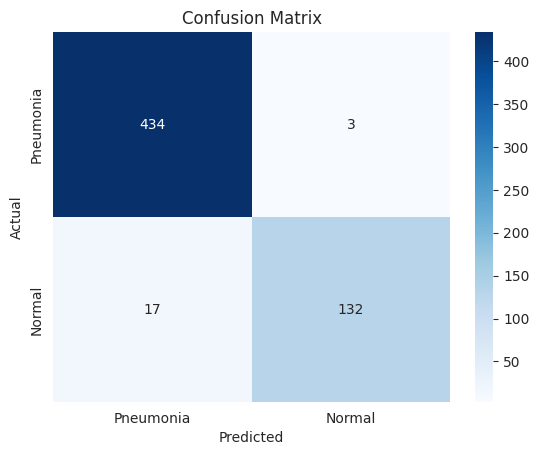

In [27]:
conf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pneumonia', 'Normal'],
            yticklabels=['Pneumonia', 'Normal'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save confusion matrix to file
conf_matrix_df = pd.DataFrame(conf_matrix, columns=labels, index=labels)
conf_matrix_df.to_csv(os.path.join(res_dir, "confusion_matrix.csv"))

In [28]:
report = classification_report(y_test, predictions, target_names=['Pneumonia', 'Normal'])
print(report)

# Save classification report to file
with open(os.path.join(res_dir, "classification_report.txt"), "w") as f:
    f.write(report)

              precision    recall  f1-score   support

   Pneumonia       0.96      0.99      0.98       437
      Normal       0.98      0.89      0.93       149

    accuracy                           0.97       586
   macro avg       0.97      0.94      0.95       586
weighted avg       0.97      0.97      0.97       586

